# Feature Governance - Financial Capacity (The "Can They Pay?" Factors)

BayesRisk Project

**Author:** Desmond Momanyi Mariita

**Date:** 2026-01-11

---

## 1. Objectives
This batch covers the most critical component of credit risk: Capacity. These variables measure the borrower's raw ability to repay the loan based on their income and existing debts.

The "Capacity" Variables:

1. annual_inc (Annual Income)

2. dti (Debt-to-Income Ratio)

3. installment (Monthly Loan Payment)

4. verification_status (Was income verified by LC?)

#### 1. Setup & Load
We start by loading the dataset that came out of Batch 1 (the one with cleaned personal features).

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data from the previous step

file_path = '../../data/interim/loans_batch1.pkl' 
df = pd.read_pickle(file_path)

# Define Batch 2 features
capacity_cols = ['annual_inc', 'dti', 'installment', 'verification_status']

print(f"Analyzing {len(capacity_cols)} capacity features...")
display(df[capacity_cols].describe().round(2))

Analyzing 4 capacity features...


,annual_inc,dti,installment
count,1.877679e+06,1876541.00,1877679.00
mean,7.738469e+04,18.59,440.75
std,1.177209e+05,13.19,267.12
min,0.000000e+00,-1.00,4.93
25%,4.600000e+04,11.83,247.13
50%,6.500000e+04,17.72,373.94
75%,9.200000e+04,24.30,585.61
max,1.100000e+08,999.00,1719.83


#### 2. Feature Analysis (The "Outlier" Problem)
Financial data is rarely normal; it is "heavy-tailed."

- Income: Most people earn $50k-$100k, but some earn $5M. The $5M person crushes the visualization.

- DTI: Usually 10-30%, but some errors show 999%.

We must bin (group) these continuous variables to see the "Bad Rate" trend clearly.

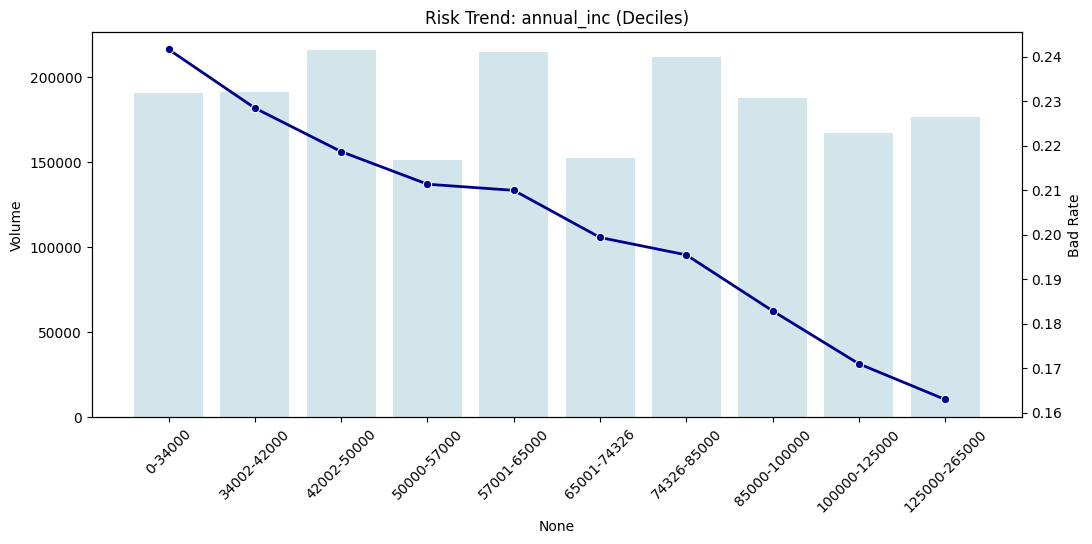

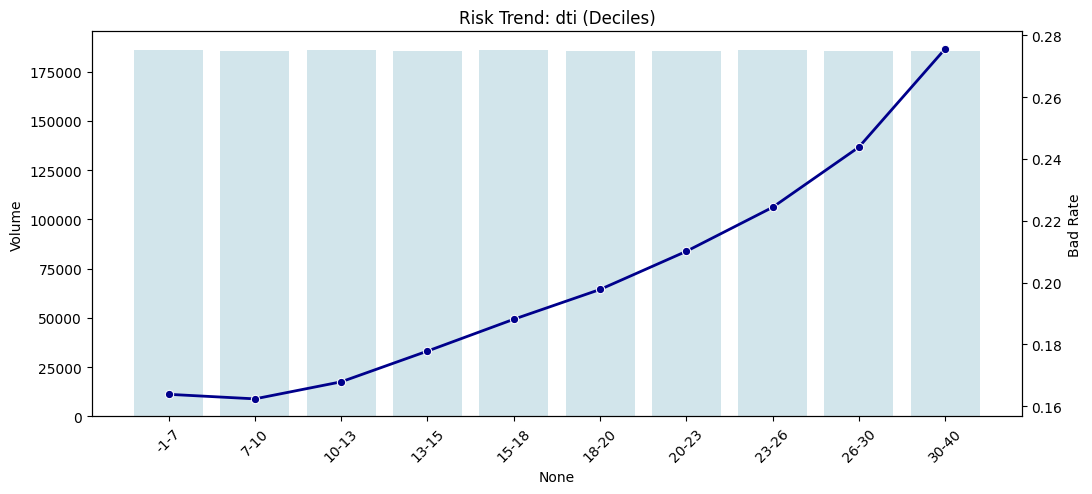

In [9]:
def analyze_continuous_risk(df: pd.DataFrame, feature: str, bins: int = 10):
    """
    Discretizes a continuous variable into equal-sized buckets (quantiles)
    and plots the Bad Rate for each bucket to reveal non-linear trends.

    Args:
        df (pd.DataFrame): Input dataframe containing the feature and target columns.
        feature (str): Name of the continuous feature to analyze.
        bins (int, optional): Number of bins to create. Defaults to 10.

    Returns:
        None

    Raises:
        ValueError: If binning fails due to excessive duplicates and fallback also fails.
    """
    # Create a temporary copy
    temp_df = df[[feature, 'target']].copy()
    
    # Handle outliers for visualization: clip at 99th percentile
    # This prevents one billionaire from stretching the x-axis too far
    upper_limit = temp_df[feature].quantile(0.99)
    temp_df = temp_df[temp_df[feature] <= upper_limit]
    
    # Create quantiles (e.g., Deciles)
    try:
        temp_df['bucket'] = pd.qcut(temp_df[feature], q=bins, duplicates='drop')
    except ValueError:
        # Fallback if too many duplicate values (e.g. lots of 0s)
        temp_df['bucket'] = pd.cut(temp_df[feature], bins=bins)
        
    # Group and Calculate Bad Rate
    group = temp_df.groupby('bucket', observed=False).agg(
        min_value=(feature, 'min'),
        max_value=(feature, 'max'),
        total=('target', 'count'),
        bad=('target', 'sum')
    ).reset_index()
    
    group['bad_rate'] = group['bad'] / group['total']
    
    # Plot
    plt.figure(figsize=(12, 5))
    ax1 = sns.barplot(x=group.index, y='total', data=group, color='lightblue', alpha=0.6)
    ax2 = ax1.twinx()
    sns.lineplot(x=group.index, y='bad_rate', data=group, marker='o', color='darkblue', lw=2, ax=ax2)
    
    # Labeling
    ax1.set_xticks(range(len(group)))
    ax1.set_xticklabels([f"{row['min_value']:.0f}-{row['max_value']:.0f}" for _, row in group.iterrows()], rotation=45)
    ax1.set_ylabel('Volume')
    ax2.set_ylabel('Bad Rate')
    plt.title(f'Risk Trend: {feature} (Deciles)')
    plt.show()

# Run the analysis
analyze_continuous_risk(df, 'annual_inc')
analyze_continuous_risk(df, 'dti')

#### 3. The "Verification" Paradox
Warning: verification_status is tricky. You might find that "Verified" borrowers have a higher default rate than "Not Verified."

- Why? Selection Bias. LendingClub only bothers to verify income if the application looks "shaky" or the loan amount is huge. Therefore, the "Verified" pool is inherently riskier to begin with.

- Decision: We keep it, but we must note this interaction effect for the model.

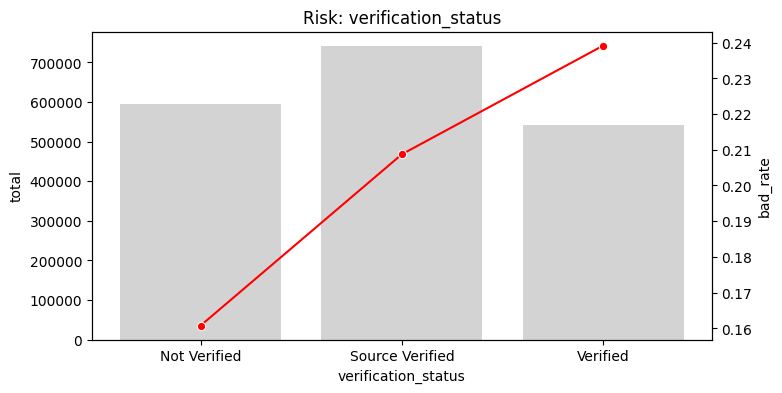

In [10]:
# Use the categorical plotter from Batch 1
# (Ideally, import it from a utils file, but re-defining for safety here)
def plot_bad_rate(df, col):
    """
    Plots the bad rate for a categorical feature.

    Args:
        df (pd.DataFrame): Input dataframe containing the feature and target columns.
        col (str): Name of the categorical feature to analyze.

    Returns:
        None

    Raises:
        None
    """
    group = df.groupby(col).agg(total=('target', 'count'), bad=('target', 'sum'))
    group['bad_rate'] = group['bad'] / group['total']
    
    fig, ax1 = plt.subplots(figsize=(8, 4))
    sns.barplot(x=group.index, y='total', data=group, color='lightgrey', ax=ax1)
    ax2 = ax1.twinx()
    sns.lineplot(x=group.index, y='bad_rate', data=group, color='red', marker='o', ax=ax2)
    plt.title(f'Risk: {col}')
    plt.show()

plot_bad_rate(df, 'verification_status')

#### 4. Governance & Cleaning Function
Now we define the transformations.

- Log Transformation: Since Income is skewed, taking the log (np.log1p) makes it "normal-ish," which helps linear models.

- Outlier Capping: We don't delete high earners, but we might cap DTI to avoid errors.

In [11]:
def clean_capacity_features(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Applies governance transformations to Financial Capacity features.
    
    Operations:
    1. annual_inc: 
       - Calculates log_annual_inc to handle skewness.
       - Caps outliers implies extreme wealth, which is good, but we verify data integrity.
    2. dti:
       - Caps at 40 (or 100) because LendingClub policies usually reject >40%. 
       - Values like 999 are likely errors/fraud.
    3. verification_status: Kept as is (categorical).
    
    Args:
        df_in (pd.DataFrame): Dataframe with capacity columns.
        
    Returns:
        pd.DataFrame: Cleaned dataframe.
        
    Raises:
        None
    """
    df_out = df_in.copy()
    
    # --- 1. Annual Income ---
    # Log transform handles the "billonaire skew" better than capping
    # We use log1p (log(1+x)) to handle potential 0s safely
    df_out['annual_inc_log'] = np.log1p(df_out['annual_inc'])
    
    # --- 2. Debt-to-Income (DTI) ---
    # Anyone with DTI > 100% is technically insolvent or it's a data error.
    # We will cap it at 100 for stability.
    df_out['dti_cleaned'] = df_out['dti'].clip(upper=100)
    
    # Check for negative DTI (impossible) and set to 0
    df_out['dti_cleaned'] = df_out['dti_cleaned'].clip(lower=0)
    
    return df_out

# Apply
df_clean_cap = clean_capacity_features(df)

print("Batch 2 Cleaning Complete.")
display(df_clean_cap[['annual_inc', 'annual_inc_log', 'dti', 'dti_cleaned']].head())

Batch 2 Cleaning Complete.


,annual_inc,annual_inc_log,dti,dti_cleaned
0,24000.0,10.085851,27.65,27.65
1,30000.0,10.308986,1.00,1.00
2,12252.0,9.413526,8.72,8.72
3,49200.0,10.803669,20.00,20.00
4,80000.0,11.289794,17.94,17.94


In [12]:
df_clean_cap.to_pickle('../../data/interim/loans_batch2.pkl')
print("Base modeling data saved.")

Base modeling data saved.
